# IMPORT

## Libraries

In [2]:
import numpy as np
import matplotlib.pyplot as plt

## Data

In [3]:
from novelty_detection.data import load_data

test_x = load_data('test_synthetic_data_with_outliers.txt')
train_x = load_data('train_synthetic_data.txt')

test_x=test_x.to_numpy()
train_x=train_x.to_numpy()

# PREPROCESSING

## Scale

In [4]:
from novelty_detection.preprocessing import minmax_scaler_given_parameters, std_scaler_given_parameters
max_val = train_x.max()
min_val = train_x.min()
mu = train_x.mean(0)
s = train_x.std(0)


train_x_norm = minmax_scaler_given_parameters(train_x, min_val, max_val)
test_x_norm = minmax_scaler_given_parameters(test_x, min_val, max_val)

#train_x_norm = std_scaler_given_parameters(training, mu, s)
#test_x_norm = std_scaler_given_parameters(evaluation, mu, s)


# DATA ANALYSIS

Size of the training data

In [5]:
N, dim = train_x.shape
print(f'number of samples: {N}')
print(f'dimension of data: {dim}')

number of samples: 2000
dimension of data: 3


Dispersion of the data. the problem here is that there are two clouds of data very differenciated.

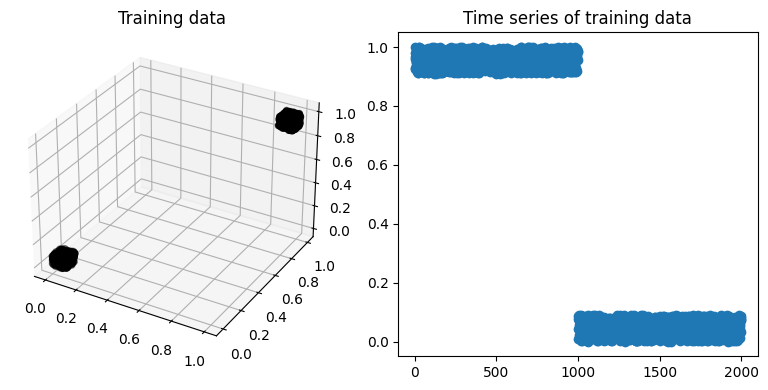

In [6]:
fig = plt.figure(figsize=(8, 4))
ax = fig.add_subplot(121, projection='3d')
ax.scatter(train_x_norm[:, 0], train_x_norm[:, 1], train_x_norm[:, 2], c='black')
ax.set_title('Training data', loc='center')


ax = fig.add_subplot(122)
ax.scatter(np.arange(train_x_norm.shape[0]), train_x_norm[:,0])
ax.set_title('Time series of training data')

plt.tight_layout()

Dispersion of all the data

In [7]:
# Measure of dispersion
variance = np.var(train_x_norm)
std_deviation = np.std(train_x_norm)
iqr = np.percentile(train_x_norm, 75) - np.percentile(train_x_norm, 25)
data_range = np.max(train_x_norm) - np.min(train_x_norm)

print(f"Variance: {variance}")
print(f"Standard Deviation: {std_deviation}")
print(f"IQR: {iqr}")
print(f"Range: {data_range}")

Variance: 0.20730985201208577
Standard Deviation: 0.4553129165882358
IQR: 0.9083974963483779
Range: 1.0


Dispersion of the data by their cluster

In [8]:
cloud1 = train_x_norm[:999]
cloud2 = train_x_norm[1000:]

In [9]:
# Measure of dispersion
variance = np.var(cloud1)
std_deviation = np.std(cloud1)
iqr = np.percentile(cloud1, 75) - np.percentile(cloud1, 25)
data_range = np.max(cloud1) - np.min(cloud1)

print('-- CLOUD 1 --')
print(f"Variance: {variance}")
print(f"Standard Deviation: {std_deviation}")
print(f"IQR: {iqr}")
print(f"Range: {data_range}")

-- CLOUD 1 --
Variance: 0.0007092425613949069
Standard Deviation: 0.02663160831408623
IQR: 0.04663784428170048
Range: 0.09087834407174034


In [10]:
# Measure of dispersion
variance = np.var(cloud2)
std_deviation = np.std(cloud2)
iqr = np.percentile(cloud2, 75) - np.percentile(cloud2, 25)
data_range = np.max(cloud2) - np.min(cloud2)

print('-- CLOUD 2 --')
print(f"Variance: {variance}")
print(f"Standard Deviation: {std_deviation}")
print(f"IQR: {iqr}")
print(f"Range: {data_range}")

-- CLOUD 2 --
Variance: 0.0006780014788984365
Standard Deviation: 0.026038461530943732
IQR: 0.04426020256504183
Range: 0.09084478893857549


Measure of dispersion using the centroid (results for cloud 1 only)

In [11]:
# Calculate the centroid
centroid = np.mean(cloud1, axis=0)

# Calculate Euclidean distances from the centroid for each point
distances = np.linalg.norm(cloud1 - centroid, axis=1)

# Calculate standard deviation of distances
std_distance = np.std(distances)

print('new metric:', std_distance)

new metric: 0.012257500082558812


# SOM PARAMETER COMPUTATION

A rule of thumb to set the size of the grid for a dimensionality reduction task is that it should contain 5*sqrt(N) neurons where N is the number of samples in the dataset to analyze.

In [25]:
som_neurons = int(5 * np.sqrt(N))
som_grid_size_ini = int(np.ceil(np.sqrt(som_neurons)))
print(f'initial guess som grid size: ({som_grid_size_ini},{som_grid_size_ini})')

initial guess som grid size: (15,15)


# TRAINING

Try different som_grid_size and see which one gives a lower percent of neurons without a hit

In [34]:
from novelty_detection.som import SOM
from novelty_detection.som_metrics import SOMmetrics

for i in range(3,30):
    model=SOM(som_grid_size=(i,i))
    model=model.fit(train_x_norm)
    metrics=SOMmetrics(model.som)
    freq_map=metrics.find_bmu_counts(train_x_norm, model.som)
    zeros = np.sum(freq_map == 0)
    percent_of_zeros = 100 * zeros / (model.som.shape[0]*model.som.shape[1])

    print(f'% of neurons without a hit: {percent_of_zeros}, given a som size of ({i},{i})')

% of neurons without a hit: 33.333333333333336, given a som size of (3,3)
% of neurons without a hit: 25.0, given a som size of (4,4)
% of neurons without a hit: 20.0, given a som size of (5,5)
% of neurons without a hit: 16.666666666666668, given a som size of (6,6)
% of neurons without a hit: 14.285714285714286, given a som size of (7,7)
% of neurons without a hit: 12.5, given a som size of (8,8)
% of neurons without a hit: 11.11111111111111, given a som size of (9,9)
% of neurons without a hit: 10.0, given a som size of (10,10)
% of neurons without a hit: 9.090909090909092, given a som size of (11,11)
% of neurons without a hit: 8.333333333333334, given a som size of (12,12)
% of neurons without a hit: 7.6923076923076925, given a som size of (13,13)
% of neurons without a hit: 7.653061224489796, given a som size of (14,14)
% of neurons without a hit: 7.111111111111111, given a som size of (15,15)
% of neurons without a hit: 6.640625, given a som size of (16,16)
% of neurons without 

As it can be seen the best som size is between 13 and 22.